# Tutorial: Tensorflow and Keras 
## CS175 Discussion #3,  Jan. 24th, 2018
Author: [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/)

### Goals of this Lesson
- Introduce...
    - Tensorflow
    - Keras (using Tensorflow backend)
    
- Implement... 
    - Logistic Regression
    - Feedforward Neural Network

### References 
- [*Tensorflow*: Getting Started](https://www.tensorflow.org/get_started/get_started) 
- ["Hello world" in Keras](https://github.com/fastforwardlabs/keras-hello-world/blob/master/kerashelloworld.ipynb)
- [*Neural Networks and Deep Learning* by Michael Nielsen](http://neuralnetworksanddeeplearning.com/)

## 0.  Python Preliminaries
As usual, first we need to import Numpy, Pandas, MatPlotLib...

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

I've created two functions that we'll use later to visualize which datapoints are being assigned to which classes.  They are a bit messy and not essential to the material so don't worry about understanding them.  I'll be happy to explain them to anyone interested during office hours.  

In [38]:
from matplotlib.colors import ListedColormap

# A somewhat complicated function to make pretty plots
def plot_classification_data(data1, data2, beta, logistic_flag=False):
    def logistic(z): return 1./(1+np.exp(-z))
    
    plt.figure()
    grid_size = .2
    features = np.vstack((data1, data2))
    # generate a grid over the plot
    x_min, x_max = features[:, 0].min() - .5, features[:, 0].max() + .5
    y_min, y_max = features[:, 1].min() - .5, features[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_size), np.arange(y_min, y_max, grid_size))
    # color the grid based on the predictions 
    if logistic_flag:
        Z = logistic(np.dot(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])], beta))
        colorbar_label=r"Value of f($X \beta)$"
    else:
        Z = np.dot(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])], beta)
        colorbar_label=r"Value of $X \beta$"
    Z = Z.reshape(xx.shape)
    background_img = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)
    
    # Also plot the training points
    plt.scatter(class1_features[:, 0], class1_features[:, 1], c='b', edgecolors='k', s=70)
    plt.scatter(class2_features[:, 0], class2_features[:, 1], c='r', edgecolors='k', s=70)
    plt.title('Data with Class Prediction Intensities')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    color_bar = plt.colorbar(background_img, orientation='horizontal')
    color_bar.set_label(colorbar_label)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

# Another messy looking function to make pretty plots of basketball courts
def visualize_court(log_reg_model, court_image = './data/nba_experiment/nba_court.png'):
    two_class_cmap = ListedColormap(['#FFAAAA', '#AAFFAA']) # light red for miss, light green for make
    x_min, x_max = 0, 50 #width (feet) of NBA court
    y_min, y_max = 0, 47 #length (feet) of NBA half-court
    grid_step_size = 0.2
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, grid_step_size), np.arange(y_min, y_max, grid_step_size))
    grid_predictions = log_reg_model.predict(np.c_[grid_x.ravel(), grid_y.ravel()])
    grid_predictions = grid_predictions.reshape(grid_x.shape)
    fig, ax = plt.subplots()
    court_image = plt.imread(court_image)
    ax.imshow(court_image, interpolation='bilinear', origin='lower',extent=[x_min,x_max,y_min,y_max])
    ax.imshow(grid_predictions, cmap=two_class_cmap, interpolation = 'nearest',
              alpha = 0.60, origin='lower',extent=[x_min,x_max,y_min,y_max])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title( "Make / Miss Prediction Boundaries" )
    plt.show()

In [26]:
### function for shuffling the data and labels
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in range(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

## 1.  Tensorflow

[Tensorflow](https://www.tensorflow.org/) is a library for computation on symbolic graphs.  Instead of defining variables with specific values and operations that execute immediately, in Tensorflow, we first define variables and operations on them---the computation graph.  Once the graph is defined, we can execute it for particular values.  First, let's import the library...  

In [27]:
import tensorflow as tf

Next, let's define a (very simple) computation graph...

In [28]:
X = tf.placeholder(dtype="float", shape=[None, 1])
Y = X**2

Now let's execute the graph...

In [29]:
# sample some random numbers
input_value = np.random.normal(size=(5,1))
print("Input Value (X):")
print(input_value)

# run the computation graph
with tf.Session() as s:
    y_output = s.run(fetches=Y, feed_dict={X: input_value})

print("\nOutput Value (Y = X^2):")
print(y_output)

Input Value (X):
[[-0.45219106]
 [-1.12175386]
 [ 0.67943537]
 [-1.07010148]
 [ 0.79607712]]

Output Value (Y = X^2):
[[ 0.20447674]
 [ 1.25833166]
 [ 0.46163243]
 [ 1.14511716]
 [ 0.63373882]]


## 2.  Automatic Differentiation in Tensorflow

A big benefit of building a computation graph is that we have some data structure that tells us the sequence of operations applied to a variable.  Then, given some lookup table of derivatives, it's easy to programatically apply [the chain rule](https://en.wikipedia.org/wiki/Chain_rule), replacing each operations with its derivative.  This allows Tensorflow to perform what's called [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).  Let's look at an example...    

In [30]:
X = tf.placeholder(dtype="float", shape=[None, 1])
Y = X**2
Z = tf.gradients(ys = Y, xs = X)

In [31]:
# sample some random numbers
input_value = np.random.normal(size=(5,1))
print("Input Value (X):")
print(input_value)

# run the computation graph
with tf.Session() as s:
    # should return 2*X
    z_output = s.run(fetches=Z, feed_dict={X: input_value})[0]

print("\nOutput Value (Z = dY/dX = 2*X):")
print(z_output)

Input Value (X):
[[-0.52173904]
 [-1.00067137]
 [-0.44962119]
 [ 1.83398556]
 [ 1.22733481]]

Output Value (Z = dY/dX = 2*X):
[[-1.04347813]
 [-2.00134277]
 [-0.8992424 ]
 [ 3.66797113]
 [ 2.45466971]]


## 3.  Logistic Regression in Tensorflow

Given this auto. diff. feature, it's no wonder that Tensorflow is widely used for machine learning: for gradient-based model training, all we need to do is define the 'forward' model and Tensorflow can derive the necessary gradient w.r.t the model parameters.  Now let's look at a full but simple example.  Recall the logistic regression model: $$ \hat{y}_{i} = f(\mathbf{x}_{i} \boldsymbol{\beta}) \ \  \text{ where } \ \ f(z) = 1/(1 + e^{-z})$$ and $\boldsymbol{\beta}$ is the vector of parameters we need to learn / estimate from the data $\{ (\mathbf{x}_{i}, y_{i}) \}$.  

We can define such a model in Tensorflow.  Let's start with the variables...

### Define Variables

In [62]:
n_dims = 3

# define feature vector
X = tf.placeholder(dtype="float", shape=[None, n_dims])

# define labels
Y = tf.placeholder(dtype="float", shape=[None, 1])

# define parameter vector
Beta = tf.Variable(tf.random_normal([n_dims, 1], stddev=.001))

And now let's define the model...

### Define Model

In [63]:
# squashing function to map to (0, 1)
def logistic_fn(z):
    return 1./(1. + tf.exp(-z))

# model definition
Y_hat = logistic_fn( tf.matmul(X, Beta) )

Now we move on to a new step: model optimization.  We could use the tf.gradients() function to get the derivatives and perform the update to $\boldsymbol{\beta}$ ourselves, but Tensorflow has high-level wrappers to perform updates.  Thus, we next define a loss function and an optimizer...

### Define Loss Function and Optimizer

In [68]:
# define cross-entropy loss function
loss_fn = tf.reduce_sum(-Y * tf.log(Y_hat) + -(1-Y) * tf.log(1-Y_hat))

# define stochastic gradient optimizer
learning_rate = 0.0001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_fn, var_list=[Beta])

Lastly, let's train the model on the same simulated data used in the last dicsussion...

### Train on Artificial Data

In [69]:
# set the random number generator for reproducability
np.random.seed(182)

#### create artificial data
N = 400
D = 2

# Sample the features from a Multivariate Normal Dist.
mean1 = [13.,5.]
mean2 = [5.,5.]
covariance = [[13.,5.],[5.,13.]]
class1_features = np.random.multivariate_normal(mean1, covariance, int(N/2))
class2_features = np.random.multivariate_normal(mean2, covariance, int(N/2))
features = np.vstack((class1_features, class2_features))

# add column of ones for bias term
features = np.hstack((features,np.ones((N,1))))

# Set the class labels
class1_labels = [0]*int(N/2)
class2_labels = [1]*int(N/2)
class_labels = class1_labels+class2_labels

# shuffle the data
shuffle_in_unison(features, class_labels)
class_labels = np.array(class_labels)[np.newaxis].T

Now visualize the data with color-codes for each class...

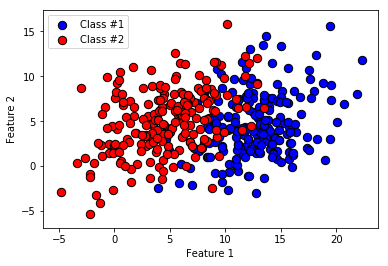

In [70]:
# visualize the data
plt.scatter(class1_features[:, 0], class1_features[:, 1], c='b', edgecolors='k', s=70, label="Class #1")
plt.scatter(class2_features[:, 0], class2_features[:, 1], c='r', edgecolors='k', s=70, label="Class #2")

plt.legend(loc=2)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Epoch 20, Cross-Entropy Loss: 175.265
Epoch 40, Cross-Entropy Loss: 167.104
Epoch 60, Cross-Entropy Loss: 163.419
Epoch 80, Cross-Entropy Loss: 160.557
Epoch 100, Cross-Entropy Loss: 157.980
Epoch 120, Cross-Entropy Loss: 155.573
Epoch 140, Cross-Entropy Loss: 153.303
Epoch 160, Cross-Entropy Loss: 151.157
Epoch 180, Cross-Entropy Loss: 149.125
Epoch 200, Cross-Entropy Loss: 147.200
Epoch 220, Cross-Entropy Loss: 145.376
Epoch 240, Cross-Entropy Loss: 143.646
Epoch 260, Cross-Entropy Loss: 142.005
Epoch 280, Cross-Entropy Loss: 140.446
Epoch 300, Cross-Entropy Loss: 138.966

Training ended after 299 iterations, taking a total of 0.21 seconds.
Final Cross-Entropy Error: 138.97
Classification Error on Training Set: 14.75%


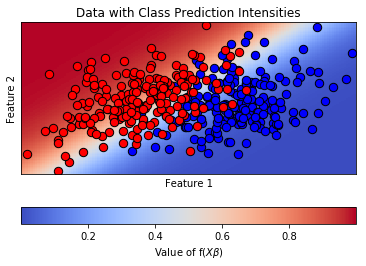

In [71]:
error = []

# run the computation graph
with tf.Session() as s:
    # this initializes the Beta variable (and any other tf.variable's)
    s.run(tf.global_variables_initializer())
    
    # Run Gradient Descent
    start_time = time.time()
    # loop until iteration threshold is reached
    for iter_idx in range(300):
    
        _, current_loss = s.run(fetches=[optimizer, loss_fn], feed_dict={X: features, Y: class_labels})
        
        error.append(current_loss)
        if (iter_idx+1) % 20 == 0:
            print("Epoch %d, Cross-Entropy Loss: %.3f" %(iter_idx+1, current_loss))
    
    end_time = time.time()
    print("\nTraining ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time))
    print("Final Cross-Entropy Error: %.2f" %(error[-1]))

    # compute error on training data
    predictions = s.run(fetches=Y_hat, feed_dict={X: features, Y: class_labels})
    print("Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100))
    
    # get current value of regression parameters from comp. graph
    beta = s.run(fetches=Beta)

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

## 4.  Neural Networks in Tensorflow

Now let's consider a slightly more complicated model: a neural network.  Recall that neural networks are basically just a bunch of stacked logistic regression models: $$ \mathbf{h}_{i} = f(\mathbf{x}_{i} \boldsymbol{\beta}_{1}) \text{, } \ \ \hat{y}_{i} = f(\mathbf{h}_{i} \boldsymbol{\beta}_{2} + b)$$ where $f(\cdot)$ is again the logistic function and $\{\boldsymbol{\beta}_{1}, \boldsymbol{\beta}_{2}, b\}$ are the parameters.  

### Define Variables

In [82]:
n_input_dims = 3
n_hidden_dims = 20

# define feature vector
X = tf.placeholder(dtype="float", shape=[None, n_input_dims])

# define labels
Y = tf.placeholder(dtype="float", shape=[None, 1])

# define parameters
params = {'beta1': tf.Variable(tf.random_normal([n_input_dims, n_hidden_dims], stddev=.001)),
          'beta2': tf.Variable(tf.random_normal([n_hidden_dims, 1], stddev=.001)),
          'b': tf.Variable(tf.random_normal([1, 1], stddev=.001))
         }

### Define Model

In [83]:
# neural net model definition
h = logistic_fn( tf.matmul(X, params['beta1']) )
Y_hat = logistic_fn( tf.matmul(h, params['beta2']) + params['b'] )

### Define Loss Function and Optimizer

In [84]:
# define cross-entropy loss function
loss_fn = tf.reduce_sum(-Y * tf.log(Y_hat) + -(1-Y) * tf.log(1-Y_hat))

# define stochastic gradient optimizer
learning_rate = 0.001
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss_fn, var_list=[params['beta1'], params['beta2'], params['b']])

### Train on Artificial Data

Epoch 20, Cross-Entropy Loss: 275.767
Epoch 40, Cross-Entropy Loss: 193.715
Epoch 60, Cross-Entropy Loss: 136.118
Epoch 80, Cross-Entropy Loss: 122.975
Epoch 100, Cross-Entropy Loss: 116.395
Epoch 120, Cross-Entropy Loss: 112.104
Epoch 140, Cross-Entropy Loss: 109.055
Epoch 160, Cross-Entropy Loss: 106.812
Epoch 180, Cross-Entropy Loss: 105.136
Epoch 200, Cross-Entropy Loss: 103.868
Epoch 220, Cross-Entropy Loss: 102.898
Epoch 240, Cross-Entropy Loss: 102.148
Epoch 260, Cross-Entropy Loss: 101.563
Epoch 280, Cross-Entropy Loss: 101.417
Epoch 300, Cross-Entropy Loss: 104.450

Training ended after 299 iterations, taking a total of 0.26 seconds.
Final Cross-Entropy Error: 104.45
Classification Error on Training Set: 11.00%


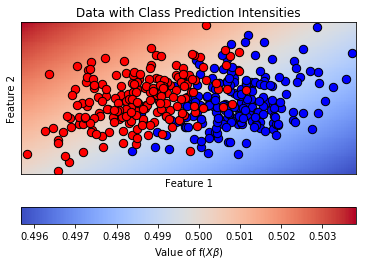

In [85]:
error = []

# run the computation graph
with tf.Session() as s:
    # this initializes the Beta variable (and any other tf.variable's)
    s.run(tf.global_variables_initializer())
    
    # Run Gradient Descent
    start_time = time.time()
    # loop until iteration threshold is reached
    for iter_idx in range(300):
    
        _, current_loss = s.run(fetches=[optimizer, loss_fn], feed_dict={X: features, Y: class_labels})
        
        error.append(current_loss)
        if (iter_idx+1) % 20 == 0:
            print("Epoch %d, Cross-Entropy Loss: %.3f" %(iter_idx+1, current_loss))
    
    end_time = time.time()
    print("\nTraining ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time))
    print("Final Cross-Entropy Error: %.2f" %(error[-1]))

    # compute error on training data
    predictions = s.run(fetches=Y_hat, feed_dict={X: features, Y: class_labels})
    print("Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100))
    
    # get current value of regression parameters from comp. graph
    beta = s.run(fetches=Beta)

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

## 5.  Logistic Regression in Keras

Next let's look at [Keras](https://keras.io/).  Keras acts as a wrapper around Tensorflow (and other auto-diff libraries such as [Theano](http://deeplearning.net/software/theano/)), giving the user higher-level abstractions for the layers that are typical in neural networks.  The user defines a model and adds layers to it sequentially.  

Now let's re-do our logistic regression model using Keras.  There's no need to define variables any long; we'll jump straight to the model definition...  

### Define Model

In [106]:
import keras.optimizers
from keras.models import Sequential 
from keras.layers import Dense, Activation 

model = Sequential() 
model.add( Dense(units=1, activation="sigmoid", input_dim=n_input_dims, use_bias=False) ) 

Like when using Tensorflow, we next define a loss function and an optimizer...

### Define Loss Function and Optimizer

In [109]:
sgd = keras.optimizers.SGD(lr=0.0001*400)
model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

In [110]:
train_log = model.fit(features, class_labels, batch_size=features.shape[0], epochs=300) 

Epoch 1/300
400/400 [==============================] - 0s 454us/step - loss: 3.0933 - acc: 0.1825
Epoch 2/300
400/400 [==============================] - 0s 7us/step - loss: 2.5446 - acc: 0.2350
Epoch 3/300
400/400 [==============================] - 0s 6us/step - loss: 2.2169 - acc: 0.2825
Epoch 4/300
400/400 [==============================] - 0s 7us/step - loss: 1.9890 - acc: 0.3175
Epoch 5/300
400/400 [==============================] - 0s 6us/step - loss: 1.7969 - acc: 0.3350
Epoch 6/300
400/400 [==============================] - 0s 7us/step - loss: 1.6200 - acc: 0.3500
Epoch 7/300
400/400 [==============================] - 0s 7us/step - loss: 1.4537 - acc: 0.3650
Epoch 8/300
400/400 [==============================] - 0s 7us/step - loss: 1.2981 - acc: 0.3650
Epoch 9/300
400/400 [==============================] - 0s 7us/step - loss: 1.1550 - acc: 0.3875
Epoch 10/300
400/400 [==============================] - 0s 7us/step - loss: 1.0264 - acc: 0.4125
Epoch 11/300
400/400 [===============

Epoch 86/300
400/400 [==============================] - 0s 8us/step - loss: 0.3972 - acc: 0.8275
Epoch 87/300
400/400 [==============================] - 0s 7us/step - loss: 0.3968 - acc: 0.8300
Epoch 88/300
400/400 [==============================] - 0s 6us/step - loss: 0.3965 - acc: 0.8300
Epoch 89/300
400/400 [==============================] - 0s 7us/step - loss: 0.3962 - acc: 0.8300
Epoch 90/300
400/400 [==============================] - 0s 7us/step - loss: 0.3959 - acc: 0.8300
Epoch 91/300
400/400 [==============================] - 0s 7us/step - loss: 0.3955 - acc: 0.8300
Epoch 92/300
400/400 [==============================] - 0s 7us/step - loss: 0.3952 - acc: 0.8300
Epoch 93/300
400/400 [==============================] - 0s 7us/step - loss: 0.3949 - acc: 0.8300
Epoch 94/300
400/400 [==============================] - 0s 8us/step - loss: 0.3946 - acc: 0.8300
Epoch 95/300
400/400 [==============================] - 0s 7us/step - loss: 0.3943 - acc: 0.8300
Epoch 96/300
400/400 [========

Epoch 170/300
400/400 [==============================] - 0s 7us/step - loss: 0.3734 - acc: 0.8375
Epoch 171/300
400/400 [==============================] - 0s 6us/step - loss: 0.3732 - acc: 0.8375
Epoch 172/300
400/400 [==============================] - 0s 8us/step - loss: 0.3729 - acc: 0.8375
Epoch 173/300
400/400 [==============================] - 0s 7us/step - loss: 0.3727 - acc: 0.8375
Epoch 174/300
400/400 [==============================] - 0s 7us/step - loss: 0.3724 - acc: 0.8375
Epoch 175/300
400/400 [==============================] - 0s 9us/step - loss: 0.3722 - acc: 0.8425
Epoch 176/300
400/400 [==============================] - 0s 7us/step - loss: 0.3719 - acc: 0.8425
Epoch 177/300
400/400 [==============================] - 0s 8us/step - loss: 0.3717 - acc: 0.8425
Epoch 178/300
400/400 [==============================] - 0s 6us/step - loss: 0.3714 - acc: 0.8450
Epoch 179/300
400/400 [==============================] - 0s 7us/step - loss: 0.3712 - acc: 0.8450
Epoch 180/300
400/40

Epoch 254/300
400/400 [==============================] - 0s 9us/step - loss: 0.3547 - acc: 0.8500
Epoch 255/300
400/400 [==============================] - 0s 8us/step - loss: 0.3545 - acc: 0.8500
Epoch 256/300
400/400 [==============================] - 0s 8us/step - loss: 0.3543 - acc: 0.8500
Epoch 257/300
400/400 [==============================] - 0s 7us/step - loss: 0.3541 - acc: 0.8500
Epoch 258/300
400/400 [==============================] - 0s 8us/step - loss: 0.3539 - acc: 0.8500
Epoch 259/300
400/400 [==============================] - 0s 8us/step - loss: 0.3537 - acc: 0.8500
Epoch 260/300
400/400 [==============================] - 0s 7us/step - loss: 0.3535 - acc: 0.8500
Epoch 261/300
400/400 [==============================] - 0s 7us/step - loss: 0.3533 - acc: 0.8500
Epoch 262/300
400/400 [==============================] - 0s 7us/step - loss: 0.3531 - acc: 0.8500
Epoch 263/300
400/400 [==============================] - 0s 7us/step - loss: 0.3529 - acc: 0.8500
Epoch 264/300
400/40

In [111]:
predictions = model.predict(features)
print("Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100))

Classification Error on Training Set: 14.50%


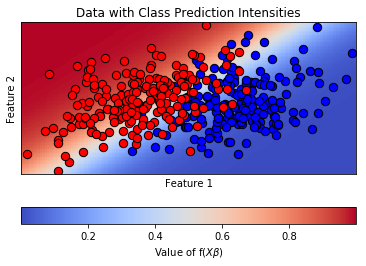

In [113]:
beta = model.layers[0].get_weights()

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

# Experiments

## 4.  Dataset #1: NBA Shot Outcomes

The first real dataset we'll tackle is one describing the location and outcome of shots taken in professional basketball games.  Let's use Pandas to load and examine the data.    

In [24]:
nba_shot_data = pd.read_csv('./data/nba_experiment/NBA_xy_features.csv')
nba_shot_data.head()

,x_Coordinate,y_Coordinate,shot_outcome
0,26.0,32.0,0.0
1,25.0,24.0,0.0
2,25.0,6.0,1.0
3,40.0,7.0,1.0
4,12.0,13.0,1.0


In [25]:
nba_shot_data.describe()

,x_Coordinate,y_Coordinate,shot_outcome
count,562538.000000,562538.000000,562538.000000
mean,25.178772,13.496301,0.458145
std,11.212500,8.651198,0.498246
min,-3.000000,1.000000,0.000000
25%,19.000000,6.000000,0.000000
50%,25.000000,10.000000,0.000000
75%,31.000000,21.000000,1.000000
max,51.000000,94.000000,1.000000


Simple enough.  Now let's train a Logistic Regression model on it, leaving out a test set.

/Users/enalisnick/anaconda/envs/cs175/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


Training ended after 0.54 seconds.
Classification Error on the Test Set: 41.87%
Baseline Error: 45.79%


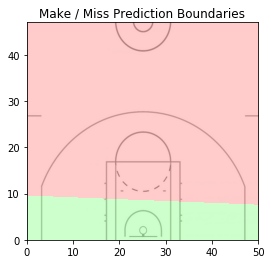

In [26]:
# split data into train and test
train_set_size = int(.80*len(nba_shot_data))
train_features = nba_shot_data.ix[:train_set_size,['x_Coordinate','y_Coordinate']]
test_features = nba_shot_data.ix[train_set_size:,['x_Coordinate','y_Coordinate']]
train_class_labels = nba_shot_data.ix[:train_set_size,['shot_outcome']]
test_class_labels = nba_shot_data.ix[train_set_size:,['shot_outcome']]

#Train it
start_time = time.time()
skl_LogReg.fit(train_features, np.ravel(train_class_labels))
end_time = time.time()
print("Training ended after %.2f seconds." %(end_time-start_time))

# compute the classification error on training data
predictions = skl_LogReg.predict(test_features)
print("Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100))

# compute the baseline error since the classes are imbalanced
print("Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100))

# visualize the boundary on the basketball court
visualize_court(skl_LogReg)

Not bad.  We're beating the random baseline of 45% error.  However, visualizing the decision boundary exposes a systemic problem with using a linear model on this dataset: it is not powerful enough to adapt to the geometry of the court.  This is a domain-specific contraint that should be considered when selecting the model and features.  For instance, a Gaussian-based classifier works a bit better, achieving 39.02% error.  Its decision boundary is visualized below.

<img src="https://raw.githubusercontent.com/enalisnick/NBA_shot_analysis/master/results/spatial_features_results/Gaussian_Mixture_Model.png" alt="" style="width: 250px;"/>

## 5.  Dataset #2: NBA Shot Outcomes Continued

Can we do better by adding more features?  For instance, if we knew the position (Guard vs. Forward vs. Center) of the player taking the shot, would that help?  Let's try.  First, load a new dataset.

In [27]:
# first we need to extract the file from the zip
import zipfile
zip = zipfile.ZipFile('./data/nba_experiment/NBA_all_features.csv.zip')
zip.extractall('./data/nba_experiment/')

nba_all_features = pd.read_csv('./data/nba_experiment/NBA_all_features.csv')
nba_all_features.head()

,x_Coordinate,y_Coordinate,layup,dunk,3pt,hook,jumper,fade_away,Guard,Forward,Center,shot_outcome
0,45.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,37.0,27.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24.0,33.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,42.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


One thing to notice is that this data is noisy.  Look at row 2 above; it says a player made a dunk from 33 feet above the baseline--that's beyond the three point line. 

Now let's train SciKit-Learn's Logistic Regression model on the *train_features* and *train_class_labels* and then compute the test classification error--which should be around 38%-39%. 

In [28]:
# split data into train and test
train_features = nba_all_features.ix[:train_set_size,:'Center']
test_features = nba_all_features.ix[train_set_size:,:'Center']
train_class_labels = nba_all_features.ix[:train_set_size,['shot_outcome']]
test_class_labels = nba_all_features.ix[train_set_size:,['shot_outcome']]

#Train it
start_time = time.time()
skl_LogReg.fit(train_features, np.ravel(train_class_labels))
end_time = time.time()
print("Training ended after %.2f seconds." %(end_time-start_time))

# compute the classification error on training data
predictions = skl_LogReg.predict(test_features)
print("Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100))

# compute the baseline error since the classes are imbalanced
print("Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100))

# we can't visualize since D>2

/Users/enalisnick/anaconda/envs/cs175/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


Training ended after 1.74 seconds.
Classification Error on the Test Set: 38.95%
Baseline Error: 45.91%


Great!  We've improved by a few percentage points.  Let's look at which features the model weighted.

In [29]:
for idx, feature in enumerate(nba_all_features):
    if idx<11:
        print("%s: %.2f" %(feature, skl_LogReg.coef_[0][idx]))

x_Coordinate: -0.00
y_Coordinate: -0.01
layup: -0.00
dunk: -0.04
3pt: -0.05
hook: 0.27
jumper: 0.86
fade_away: 0.76
Guard: 0.90
Forward: 0.28
Center: 3.08


Interestingly, the classifier exploited the location features very little.  The position of the player was much more important, especially if he was a center. 

## 6.  Dataset #3: 20 News Groups

For the second experiment, we'll work with the very popular '20 News Groups' dataset consisting of, well, 20 different categories of articles.  SciKit-Learn already has it ready for import.

In [30]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# use SciKit Learn's loading methods
categories = ['soc.religion.christian', 'alt.atheism']
train_20ng = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
test_20ng = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

# transform the text into word counts
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
train_vectors = vectorizer.fit_transform(train_20ng.data)
test_vectors = vectorizer.transform(test_20ng.data)

train_targets = train_20ng.target
test_targets = test_20ng.target

print("The training data size is "+str(train_vectors.shape))
print("The test data size is "+str(test_vectors.shape))
# print the first 500 words of an article
print("Example text:")
print(train_20ng.data[0][:500])
print("\nExample count vector:")
print(train_vectors[0].todense())

The training data size is (1079, 1000)
The test data size is (717, 1000)
Example text:
Library of Congress to Host Dead Sea Scroll Symposium April 21-22
 To: National and Assignment desks, Daybook Editor
 Contact: John Sullivan, 202-707-9216, or Lucy Suddreth, 202-707-9191
          both of the Library of Congress

   WASHINGTON, April 19  -- A symposium on the Dead Sea 
Scrolls will be held at the Library of Congress on Wednesday,
April 21, and Thursday, April 22.  The two-day program, cosponsored
by the library and Baltimore Hebrew University, with additional
support from the Pr

Example count vector:
[[ 0  0  1  0  1  0  0  0  0  0  1  0  5  3  0  0  0  0  3  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0  0
   0  0  3  0  0  1  0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0
   0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  2  3  0  0
   0  0  0  0  0  0

As you can see, the vector is super sparse and very high dimensional--much different than the data we've been working with previously.  Let's see how SciKit-Learn's Logistic Regression model handles it.  

In [31]:
#Train it
start_time = time.time()
skl_LogReg.fit(train_vectors, train_targets)
end_time = time.time()
print("Training ended after %.2f seconds." %(end_time-start_time))

# compute the classification error on training data
predictions = skl_LogReg.predict(test_vectors)
print("Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, test_targets) * 100))

# compute the baseline error since the classes are imbalanced
print("Baseline Error: %.2f%%" %(100 - sum(test_targets)*100./len(test_targets)))

Training ended after 0.02 seconds.
Classification Error on the Test Set: 23.99%
Baseline Error: 44.49%


24% error is respectable, but there's still room for improvement.  In general, working with natural language is one of the hardest application domains in Machine Learning due to the fact that we often have to reduce the abstract, sometimes ambiguous semantic meaning to a superficial token.  

## <span style="color:red">STUDENT ACTIVITY</span>

### Feature Engineering for 20 News Groups
Can you beat the baseline error rate on the 20 News Groups dataset?  One way to do this is to have better features--word counts are rather blunt.  Go read about [TFIDF](http://www.tfidf.com/) and then use SciKit-Learn's [TFIDF Vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute a new feature matrix for the 20 News Groups dataset.  You should be able to get an error rate of about 40% if not better.  The code is started for you below.

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer


#### YOUR CODE GOES HERE


print("Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, test_targets) * 100))

# compute the baseline error since the classes are imbalanced
print("Baseline Error: %.2f%%" %(100 - sum(test_targets)*100./len(test_targets)))

Classification Error on the Test Set: 23.99%
Baseline Error: 44.49%
